In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
train_path = ('./data/FIFA_train.csv')
test_path = ('./data/FIFA_test.csv')
submission_path = ('./data/submission.csv')

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

# 메모리 사용량 줄이는 테크닉
- Data type을 변경

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [7]:
train[["age", "stat_overall", "stat_potential"]] = train[["age", "stat_overall", "stat_potential"]].astype(np.int32)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int32  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int32  
 9   stat_potential    8932 non-null   int32  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int32(3), int64(1), object(5)
memory usage: 732.8+ KB


In [12]:
# 기술통계량 확인
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8932.0,7.966776e+03,4.844429e+03,0.0,3751.75,7696.5,12082.25,16948.0
age,8932.0,2.520914e+01,4.635515e+00,16.0,21.00,25.0,28.00,40.0
reputation,8932.0,1.130878e+00,4.237919e-01,1.0,1.00,1.0,1.00,5.0
stat_overall,8932.0,6.709113e+01,6.854910e+00,47.0,63.00,67.0,72.00,94.0
stat_potential,8932.0,7.199720e+01,5.988147e+00,48.0,68.00,72.0,76.00,94.0
stat_skill_moves,8932.0,2.401702e+00,7.760476e-01,1.0,2.00,2.0,3.00,5.0
value,8932.0,2.778673e+06,5.840982e+06,10000.0,375000.00,825000.0,2600000.00,110500000.0


In [13]:
# Categorical Data는 다른 형식으로 출력
train[["continent", "contract_until", "prefer_foot", "position", "name"]].describe()

,continent,contract_until,prefer_foot,position,name
count,8932,8932,8932,8932,8932
unique,5,17,2,4,8932
top,europe,2019,right,MF,K. Moriya
freq,5322,2366,6837,3428,1


In [14]:
train.sort_values(by="value", ascending=False)[:50]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
17,30,Isco,26,europe,2022,ST,right,3.0,88,91,4.0,73500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
14,26,M. Salah,26,africa,2023,MF,left,3.0,88,89,4.0,69500000.0
18,32,Coutinho,26,south america,2023,ST,right,3.0,88,89,5.0,69500000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0
26,45,P. Pogba,25,europe,2021,MF,right,4.0,87,91,5.0,64000000.0
7,14,N. Kanté,27,europe,2023,MF,right,3.0,89,90,2.0,63000000.0
27,47,R. Lukaku,25,europe,2022,ST,left,3.0,87,89,3.0,62500000.0


In [25]:
plt.style.use("fivethirtyeight")

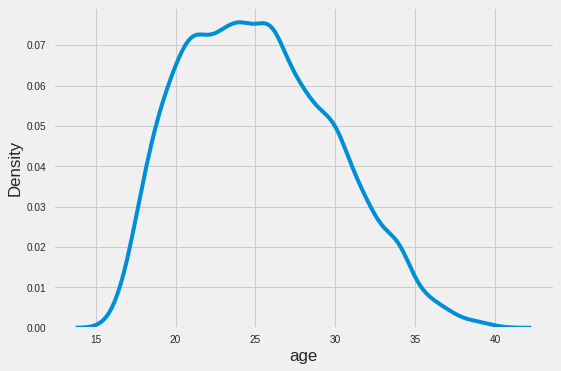

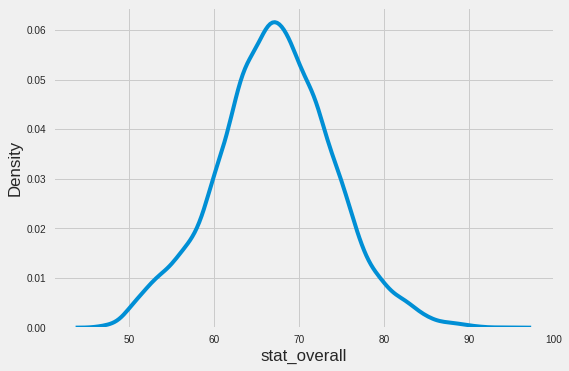

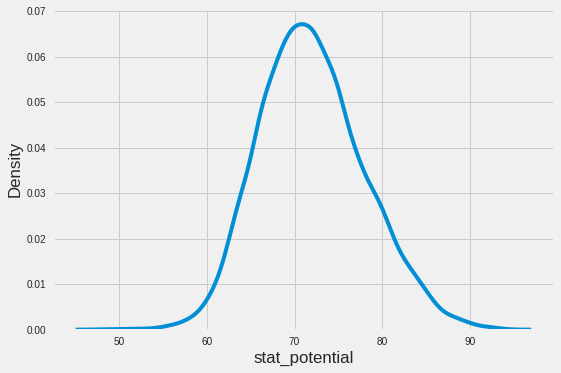

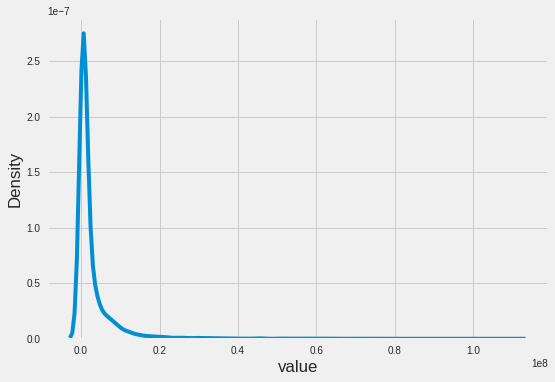

In [35]:
# Distribution
cols = ["age", "stat_overall", "stat_potential", "value"]
for col in cols:
    sns.kdeplot(train[col])
    plt.show()

In [28]:
train.head(1)

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0


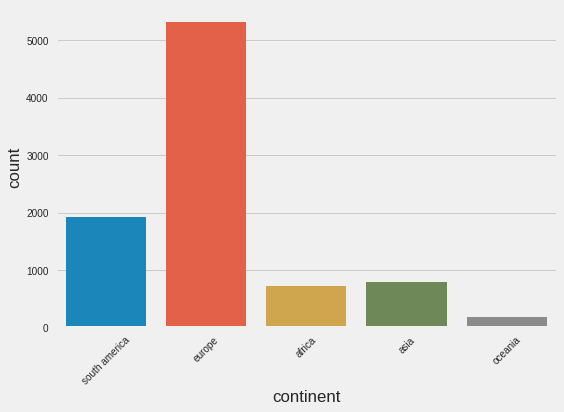

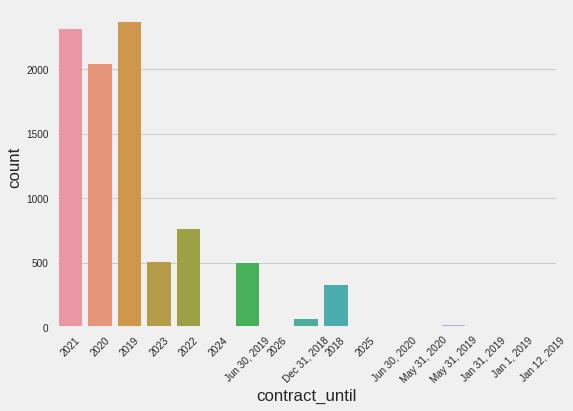

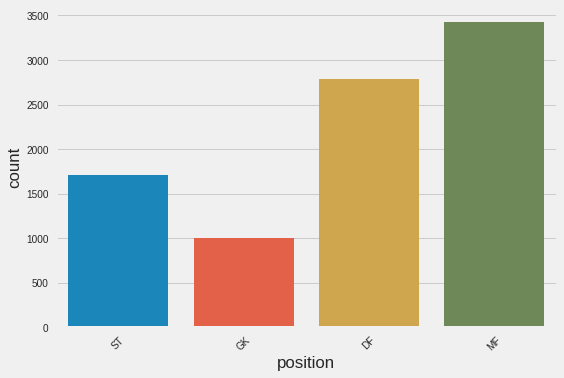

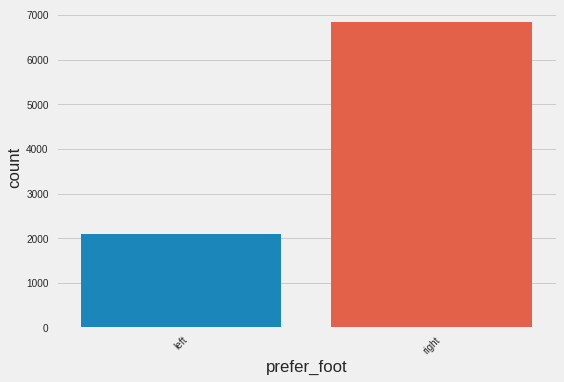

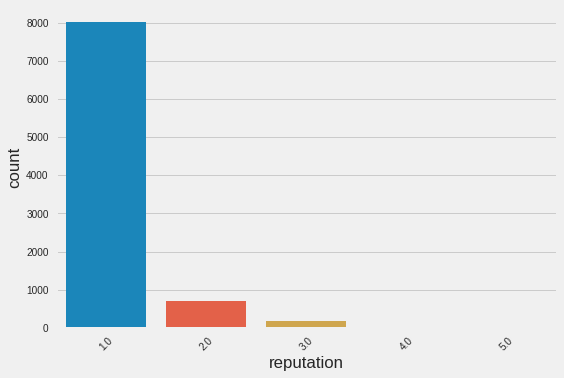

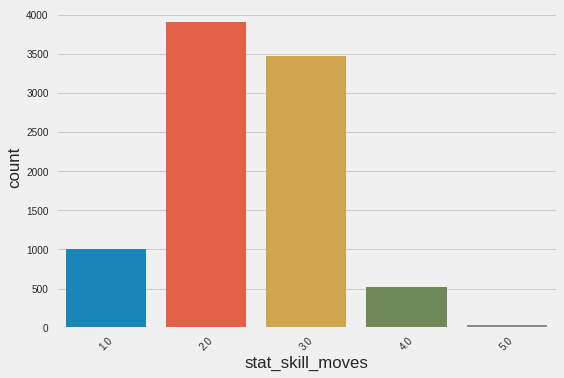

In [32]:
# countplot
cols = ["continent", "contract_until", "position", "prefer_foot", "reputation", "stat_skill_moves"]
for col in cols:
    sns.countplot(train[col])
    plt.xticks(rotation=45)
    plt.show()

In [48]:
pd.set_option("precision", 100)
train.groupby("reputation")["value"].mean()

reputation
1.0     1690091.71449962561018764972686767578125
2.0     8639220.96317280456423759460449218750000
3.0    22014830.50847457721829414367675781250000
4.0    33429032.25806451588869094848632812500000
5.0    60625000.00000000000000000000000000000000
Name: value, dtype: float64

In [73]:
train.groupby(["reputation", "stat_skill_moves"]).mean().reset_index()

,reputation,stat_skill_moves,id,age,contract_until,stat_overall,stat_potential,value,stat_potent,retire_age
0,1.0,1.0,10030.2704741379311599303036928176879882812500...,25.3642241379310355853249348001554608345031738...,2.05603448275862055183438314998056739568710327...,63.9730603448275871869554976001381874084472656...,69.8114224137931103086884832009673118591308593750,1041406.250000000000000000000000000000000,5.83836206896551690448404769995249807834625244...,9.63577586206896619103190460009500384330749511...
1,1.0,2.0,10347.1884802595996006857603788375854492187500...,24.4188750676041088638612563954666256904602050...,2.10978907517577063401859049918130040168762207...,63.8112493239588971505327208433300256729125976...,69.7747431043807466721773380413651466369628906250,982351.270957274246029555797576904296875,5.96349378042184952164461719803512096405029296...,10.5811249323958893597819042042829096317291259...
2,1.0,3.0,6835.14923427826670376816764473915100097656250...,25.0322580645161281154287280514836311340332031...,2.21668295861844244498684020072687417268753051...,68.3004235907461776378113427199423313140869140...,72.8380579993483223688599537126719951629638671875,2252813.620071684475988149642944335937500,4.53763440860215094829754889360629022121429443...,9.96774193548387010821443254826590418815612792...
3,1.0,4.0,3637.72990353697741738869808614253997802734375...,24.6848874598070722186093917116522789001464843...,2.65273311897106101042709269677288830280303955...,72.7234726688102881553277256898581981658935546...,77.0578778135048167996501433663070201873779296875,6376045.016077170148491859436035156250000,4.33440514469453397339293587720021605491638183...,10.3151125401929260050337688880972564220428466...
4,1.0,5.0,3811.12500000000000000000000000000000000000000...,25.3750000000000000000000000000000000000000000...,2.62500000000000000000000000000000000000000000...,72.3750000000000000000000000000000000000000000...,77.1250000000000000000000000000000000000000000000,6050000.000000000000000000000000000000000,4.75000000000000000000000000000000000000000000...,9.62500000000000000000000000000000000000000000...
5,2.0,1.0,1569.67272727272734300640877336263656616210937...,31.2181818181818186985765350982546806335449218...,2.38181818181818183433051672182045876979827880...,77.3090909090909121914592105895280838012695312...,78.2545454545454504113877192139625549316406250000,7947000.000000000000000000000000000000000,0.94545454545454543637816868795198388397693634...,3.78181818181818174551267475180793553590774536...
6,2.0,2.0,2314.56886227544919165666215121746063232421875...,29.7305389221556879419949837028980255126953125...,2.24550898203592819157847770838998258113861083...,75.1616766467065815504611236974596977233886718...,76.0838323353293475292957737110555171966552734375,6837245.508982036262750625610351562500000,0.92215568862275454353749637448345310986042022...,5.26946107784431116982659659697674214839935302...
7,2.0,3.0,2219.86445783132512588053941726684570312500000...,28.7771084337349414283835358219221234321594238...,2.41265060240963835624938838009256869554519653...,75.1084337349397657135341432876884937286376953...,76.1445783132530067405241425149142742156982421875,7242123.493975903838872909545898437500000,1.03614457831325301739866517891641706228256225...,6.22289156626506034797330357832834124565124511...
8,2.0,4.0,961.302816901408505145809613168239593505859375000,27.3943661971830998425048164790496230125427246...,2.39436619718309851023718692886177450418472290...,78.2535211267605603779884404502809047698974609...,80.0422535211267671684254310093820095062255859375,13671126.760563381016254425048828125000000,1.78873239436619724251897878275485709309577941...,7.60563380281690104567360322107560932636260986...
9,2.0,5.0,1092.90000000000009094947017729282379150390625...,25.5000000000000000000000000000000000000000000...,3.39999999999999991118215802998747676610946655...,78.5999999999999943156581139191985130310058593...,81.2999999999999971578290569595992565155029296875,17470000.00000

In [69]:
train.groupby(["reputation", "stat_skill_moves"])["value"].mean().index

MultiIndex([(1.0, 1.0),
            (1.0, 2.0),
            (1.0, 3.0),
            (1.0, 4.0),
            (1.0, 5.0),
            (2.0, 1.0),
            (2.0, 2.0),
            (2.0, 3.0),
            (2.0, 4.0),
            (2.0, 5.0),
            (3.0, 1.0),
            (3.0, 2.0),
            (3.0, 3.0),
            (3.0, 4.0),
            (3.0, 5.0),
            (4.0, 1.0),
            (4.0, 2.0),
            (4.0, 3.0),
            (4.0, 4.0),
            (4.0, 5.0),
            (5.0, 1.0),
            (5.0, 3.0),
            (5.0, 4.0),
            (5.0, 5.0)],
           names=['reputation', 'stat_skill_moves'])

# Feature Engineering

In [52]:
# method 확인 함수
dir(pd.Series)

['T',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__

In [47]:
train["contract_until"] = train["contract_until"].map(lambda x: x[-4:])

In [49]:
train["contract_until"].unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', '2026', '2018',
       '2025'], dtype=object)

In [50]:
# 기존의 feature 변경
train["contract_until"] = train["contract_until"].astype(np.int32)

In [53]:
train["contract_until"] = train["contract_until"] - 2018

In [54]:
train["contract_until"]

0       3
1       2
2       3
3       2
4       3
       ..
8927    1
8928    2
8929    3
8930    3
8931    2
Name: contract_until, Length: 8932, dtype: int32

<AxesSubplot:xlabel='contract_until', ylabel='count'>

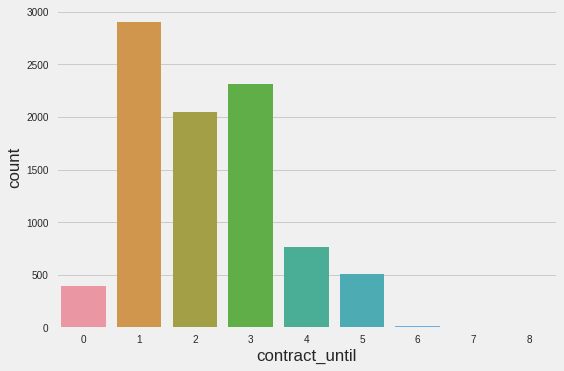

In [56]:
sns.countplot(train["contract_until"])

In [57]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,3,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,3,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,3,GK,right,3.0,90,93,1.0,68000000.0


In [58]:
# 새로운 feature 생성
train["stat_potent"] = train["stat_potential"] - train["stat_overall"]

In [59]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,stat_potent
0,0,L. Messi,31,south america,3,ST,left,5.0,94,94,4.0,110500000.0,0
1,3,De Gea,27,europe,2,GK,right,4.0,91,93,1.0,72000000.0,2
2,7,L. Suárez,31,south america,3,ST,right,5.0,91,91,3.0,80000000.0,0
3,8,Sergio Ramos,32,europe,2,DF,right,4.0,91,91,3.0,51000000.0,0
4,9,J. Oblak,25,europe,3,GK,right,3.0,90,93,1.0,68000000.0,3


In [60]:
train["retire_age"] = 35 - train["age"]

In [61]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value,stat_potent,retire_age
0,0,L. Messi,31,south america,3,ST,left,5.0,94,94,4.0,110500000.0,0,4
1,3,De Gea,27,europe,2,GK,right,4.0,91,93,1.0,72000000.0,2,8
2,7,L. Suárez,31,south america,3,ST,right,5.0,91,91,3.0,80000000.0,0,4
3,8,Sergio Ramos,32,europe,2,DF,right,4.0,91,91,3.0,51000000.0,0,3
4,9,J. Oblak,25,europe,3,GK,right,3.0,90,93,1.0,68000000.0,3,10
